## Frequency Analysis

Generating a complex pattern (distribution) from a single value can be done with dense layers, conv layer and recurrent layers. Autoencoders and Variational Autoencoders can easily be trained to decode a small latent-space vector into a complex image or waveform.

This document investigates what kinds of networks are best suited to extract the required information needed to re-generate an input waveform.

Ideally, we want a network that performs a component analysis of an input sample, and outputs the frequencies of the sinewaves that it consists of.

In [1]:
from __future__ import division

import keras
from keras import backend as K
from keras.layers import Layer
from keras import activations
from keras import utils
from keras.datasets import cifar10
from keras.models import Model
from keras.layers import *
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import TensorBoard

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
# local libs
import config, models, functions
from data import data, midi, midi_generators as g
from utils import io, models_io, utils, plot
from capsule.layers import Capsule, Length
from capsule.capsulefunctions import squash, softmax, margin_loss

 Context :: namedtuple(
[ max_t = float
, dt = float
, n_instances = int
, note_length = int
, bpm = float
, tempo = float
, ticks_per_beat = int
]



In [3]:
context = data.init()
n = 2
dim4 = True
multiTrack = True
context, x_train, labels = data.import_data(data.init(), n, dim4=dim4, multiTrack=multiTrack)

Setting up params

max min f 25.0 0.5
 >> Context(max_t=2.0, dt=0.02, n_instances=100, note_length=0.03, bpm=120.0, tempo=500000, ticks_per_beat=480)
Setting up params

max min f 25.0 0.5
 >> Context(max_t=2.0, dt=0.02, n_instances=100, note_length=0.03, bpm=120.0, tempo=500000, ticks_per_beat=480)
Importing midi-data

 [INFO] : 
 |  reading file: ../datasets/examples/simple-straight-120.mid
 [INFO] : 
 |  reading file: ../datasets/examples/simple-shuffle-120.mid

Encoding midi-data
 [<midi file '../datasets/examples/simple-straight-120.mid' type 0, 1 tracks, 68 messages>, <midi file '../datasets/examples/simple-shuffle-120.mid' type 0, 1 tracks, 68 messages>]
> -> multi-track = True
 [INFO] : 
 |  reduced dims:
 |  (2, 100, 1)


In [4]:
n = 1000
min_f = 0.001
max_f = 4
x_train, params = g.gen_data_complex(context, n, max_f=max_f, min_f=min_f,
    n_polyrythms=1,
    n_channels=1,
    d_phase=False,
    return_params=True,
    dim4=dim4,
    multiTrack=multiTrack)

 [INFO] : 
 |  reduced dims:
 |  (1000, 100, 1)


In [5]:
params.shape # n, n_channels, n_polyrythms

(1000, 1, 1)

In [6]:
x_train.shape

(1000, 100, 1, 1)

(array([ 67.,  92.,  72.,  91., 118.,  84.,  85.,  96.,  95., 100.]),
 array([2.36176029e-03, 4.01767438e-01, 8.01173115e-01, 1.20057879e+00,
        1.59998447e+00, 1.99939015e+00, 2.39879582e+00, 2.79820150e+00,
        3.19760718e+00, 3.59701286e+00, 3.99641853e+00]),
 <a list of 10 Patch objects>)

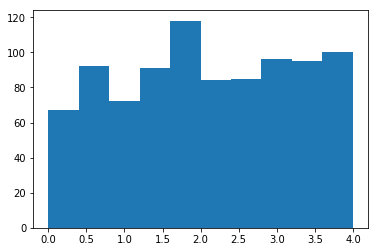

In [7]:
m = int(x_train.shape[0] * 0.9)
# m = 10
plt.hist(params[:m,0,0])

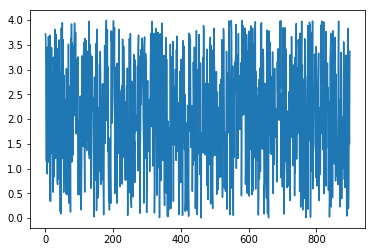

In [8]:
plt.plot(params[:m,0,0])

In [9]:
# range_ = (max_f - min_f)
range_ = max_f + 1 # extra margin = 1
y_train = params[:,0,0] / range_
y_train.shape

(1000,)

In [10]:
x_train.shape

(1000, 100, 1, 1)

In [11]:
x_test = x_train[m:]
x_train = x_train[:m]
y_test = y_train[m:]
y_train = y_train[:m]

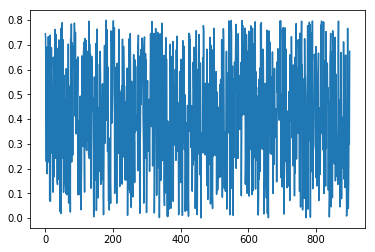

In [12]:
plt.plot(y_train)

m (30, 1)


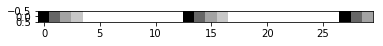

m (30, 1)


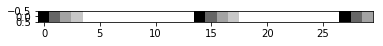

[0.7444838  0.73133816]


In [13]:
i = 0
plot.single(x_train[i,:30,0])
plot.single(x_train[i+1,:30,0])
print(y_train[i:i+2])

Make sure all frequencies fall inside the window

m (30, 1)


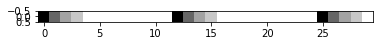

m (30, 1)


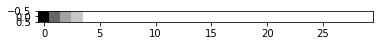

0.7992837066789173 0.00047235205807517053


In [14]:
i = y_train.argmax()
j = y_train.argmin()
plot.single(x_train[i,:30,0])
plot.single(x_train[j,:30,0])
print(y_train[i], y_train[j])

In [15]:
input_shape = x_train[0].shape
input_shape

(100, 1, 1)

In [16]:
timesteps, notes, channels = input_shape

encoder_input = Input(shape=(timesteps, notes, channels))
x = encoder_input

x = Reshape((timesteps, notes))(x)
x = SimpleRNN(1)(x)
x = Dense(1, activation='sigmoid')(x)

encoder_output = x

encoder_model = Model(encoder_input, encoder_output, name='encoder-')
encoder_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100, 1, 1)         0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 100, 1)            0         
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 1)                 3         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 2         
Total params: 5
Trainable params: 5
Non-trainable params: 0
_________________________________________________________________


In [17]:
loss = 'mse' # mse mae binary_crossentropy rmsprop adadelta
encoder_model.compile(loss=loss, optimizer='rmsprop', metrics=['accuracy','mae','binary_crossentropy'])

In [18]:
phase_mod = 0.1
whitening = False

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by dataset std
        samplewise_std_normalization=False,  # divide each input by its std
#         zca_epsilon=10,
        zca_whitening=whitening,
        rotation_range=0,  # randomly rotate images in 0 to 180 degrees
        width_shift_range=0.,  # note-channel mod, but not shuffled
        height_shift_range=phase_mod,  # start_t, phase
        horizontal_flip=False,  # reverse
        vertical_flip=False)

datagen.fit(x_train)

In [19]:
batch_size = 100
epochs = 50

In [20]:
data_augmentation = False
# data_augmentation = True

callbacks = []
# callbacks = [TensorBoard(log_dir=config.tmp_log_dir)]

if not data_augmentation:
    print('Not using data augmentation.')
#     history = ae.fit(x_train, epochs=epochs, validation_data=(x_test, None))
    history = encoder_model.fit(
        x_train,
        y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(x_test, y_test),
        callbacks=callbacks,
        shuffle=True)
else:
    print('Using real-time data augmentation.')    
    history = encoder_model.fit_generator(
        datagen.flow(x_train, y_train, batch_size=batch_size),
        epochs=epochs,
        validation_data=(x_test, y_test),
        callbacks=callbacks,
        workers=4)

Not using data augmentation.
Train on 900 samples, validate on 100 samples
Epoch 1/50
900/900 [==============================] - 0s 380us/step - loss: 0.0584 - acc: 0.0000e+00 - mean_absolute_error: 0.2044 - binary_crossentropy: 0.6935 - val_loss: 0.0686 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2219 - val_binary_crossentropy: 0.6926
Epoch 2/50
900/900 [==============================] - 0s 157us/step - loss: 0.0576 - acc: 0.0000e+00 - mean_absolute_error: 0.2035 - binary_crossentropy: 0.6920 - val_loss: 0.0679 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2214 - val_binary_crossentropy: 0.6912
Epoch 3/50
900/900 [==============================] - 0s 172us/step - loss: 0.0572 - acc: 0.0000e+00 - mean_absolute_error: 0.2028 - binary_crossentropy: 0.6911 - val_loss: 0.0673 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2210 - val_binary_crossentropy: 0.6901
Epoch 4/50
900/900 [==============================] - 0s 172us/step - loss: 0.0568 - acc: 0.0000e+00 - mean_absolut

Epoch 31/50
900/900 [==============================] - 0s 164us/step - loss: 0.0517 - acc: 0.0000e+00 - mean_absolute_error: 0.1949 - binary_crossentropy: 0.6801 - val_loss: 0.0601 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2157 - val_binary_crossentropy: 0.6755
Epoch 32/50
900/900 [==============================] - 0s 170us/step - loss: 0.0516 - acc: 0.0000e+00 - mean_absolute_error: 0.1948 - binary_crossentropy: 0.6800 - val_loss: 0.0600 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2156 - val_binary_crossentropy: 0.6753
Epoch 33/50
900/900 [==============================] - 0s 194us/step - loss: 0.0516 - acc: 0.0000e+00 - mean_absolute_error: 0.1947 - binary_crossentropy: 0.6799 - val_loss: 0.0599 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2155 - val_binary_crossentropy: 0.6752
Epoch 34/50
900/900 [==============================] - 0s 180us/step - loss: 0.0515 - acc: 0.0000e+00 - mean_absolute_error: 0.1946 - binary_crossentropy: 0.6798 - val_loss: 0.0598 - val_

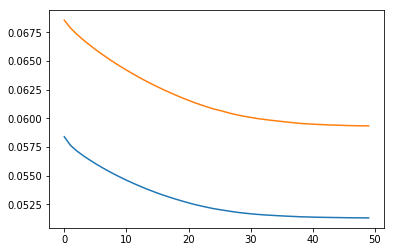

In [21]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

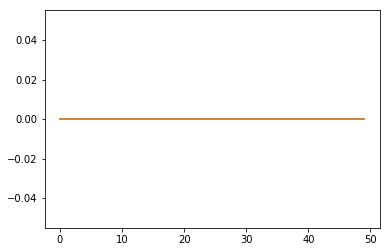

In [22]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

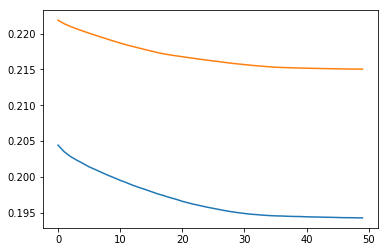

In [23]:
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])

In [24]:
i = 1
encoder_model.predict(x_train)[i]

array([0.4272855], dtype=float32)

In [25]:
y_train[i]

0.7313381585401277

In [26]:
keras.backend.cast_to_floatx(0)

array(0., dtype=float32)

In [27]:
from keras.utils.generic_utils import get_custom_objects

In [28]:
# saw = Lambda(lambda x: x % 1) # No gradient defined for operation 'mod' (op type: FloorMod)
def saw(x):
     # No gradient defined for operation 'mod' (op type: FloorMod)
    # return x % 1
    
#     return K.tf.where(x < 1, x, K.zeros_like(x))
    return K.tf.where(x < 1, x, x - 1)

def sawDescending(x):
     # No gradient defined for operation 'mod' (op type: FloorMod)
    # return x % 1
#     return K.tf.where(x > 0, x, K.ones_like(x))
    return K.tf.where(x > 0, x, x + 1)

get_custom_objects().update({'saw': Activation(saw), 'sawDescending': Activation(sawDescending)})

# make sure to import this function when loading this model in another module

In [29]:
# # saw = Lambda(lambda x: x % 1) # No gradient defined for operation 'mod' (op type: FloorMod)
# def saw(x):
#      # No gradient defined for operation 'mod' (op type: FloorMod)
#     # return x % 1
#     return K.tf.where(x < 1, x, x - 1)

# def sawDescending(x):
#      # No gradient defined for operation 'mod' (op type: FloorMod)
#     # return x % 1
#     return K.tf.where(x < 0, K.ones_like(x), x)

# get_custom_objects().update({'saw': Activation(saw), 'sawDescending': Activation(sawDescending)})

# # make sure to import this function when loading this model in another module

In [54]:
decoder_input = Input(shape=(notes,))
x = decoder_input

unroll = True

ratio = 0.1
sub_t = int(timesteps * ratio)
super_t = int(timesteps/ sub_t)

# a = ELU(alpha=0.5)
# ThresholdedReLU
# PReLU
# ELU
# LeakyRelu

# x1 = starting value
# x2 :: [decay1, decay2, decay3]
# end of sequence = decay3 * (decay2 * (decay1 * x1))
# full sequence = [decay1 * x1, decay2(decay1 * x1), etc... ]

# x1 might have abias of zero
# TODO x1 ** 0.5
# x2 might disregard its input
# TODO check if x2 can have an offset bias

# decay is non-linear?
# decay = 1/f

x1 = x
x1 = Dense(notes, activation='relu')(x1) # phase (linear)
x1 = RepeatVector(1)(x1)

x2 = x
x2 = Dense(notes, activation='relu')(x2) # e.g decay: 0.5 * decay, 0.5 * decay * decay
# x2 = Dense(notes)(x2)
# x2 = Lambda(lambda z: 1./z)(x2) # if descending
# # x2 = Lambda(lambda x: -1 * x)(x2) # if descending

# x2 = Dense(notes, activation='tanh')(x2)
x2 = Dense(notes, activation='relu')(x2)
x2 = RepeatVector(timesteps)(x2)


# SimpleRNN returns 2 states, LSTM returns 3 states
_, state = SimpleRNN(notes, return_state=True)(x1)
rnn = SimpleRNN(notes, activation='sawDescending', return_sequences=True, unroll=unroll)
# rnn = SimpleRNN(notes, return_sequences=True)
# x = rnn(x2, initial_state=x1) # shape error
x = rnn(x2, initial_state=state)

# x = Dense(1)(x)
# x = ThresholdedReLU(theta=0.5)(x)

# # Final layer
# x = Dense(notes, activation='sigmoid')(x)
x = Activation('sigmoid')(x)
x = Reshape(input_shape)(x)

decoder_output = x

decoder_model = Model(decoder_input, decoder_output, name='decoder-')
decoder_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
dense_9 (Dense)                 (None, 1)            2           input_4[0][0]                    
__________________________________________________________________________________________________
dense_8 (Dense)                 (None, 1)            2           input_4[0][0]                    
__________________________________________________________________________________________________
dense_10 (Dense)                (None, 1)            2           dense_9[0][0]                    
__________________________________________________________________________________________________
repeat_vec

In [55]:
ae = Model(decoder_input, encoder_model(decoder_model(decoder_input)))
ae.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
decoder- (Model)             (None, 100, 1, 1)         12        
_________________________________________________________________
encoder- (Model)             (None, 1)                 5         
Total params: 17
Trainable params: 12
Non-trainable params: 5
_________________________________________________________________


In [56]:
encoder_model.trainable = False

In [57]:
loss = 'mse' # mse mae binary_crossentropy rmsprop adadelta hinge
ae.compile(loss=loss, optimizer='rmsprop', metrics=['accuracy','mae','mse'])

In [58]:
batch_size = 100
epochs = 50

In [59]:
j = -1
history = ae.fit(y_train[:j], y_train[:j], 
    epochs=epochs, batch_size=batch_size, 
    validation_data=(y_test, y_test))

Train on 899 samples, validate on 100 samples
Epoch 1/50
899/899 [==============================] - 3s 3ms/step - loss: 0.0512 - acc: 0.0000e+00 - mean_absolute_error: 0.1939 - mean_squared_error: 0.0512 - val_loss: 0.0590 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2145 - val_mean_squared_error: 0.0590
Epoch 2/50
899/899 [==============================] - 0s 240us/step - loss: 0.0511 - acc: 0.0000e+00 - mean_absolute_error: 0.1938 - mean_squared_error: 0.0511 - val_loss: 0.0591 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2147 - val_mean_squared_error: 0.0591
Epoch 3/50
899/899 [==============================] - 0s 235us/step - loss: 0.0512 - acc: 0.0000e+00 - mean_absolute_error: 0.1939 - mean_squared_error: 0.0512 - val_loss: 0.0591 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2148 - val_mean_squared_error: 0.0591
Epoch 4/50
899/899 [==============================] - 0s 230us/step - loss: 0.0512 - acc: 0.0000e+00 - mean_absolute_error: 0.1939 - mean_squared_error:

In [60]:
# y_train[:j]

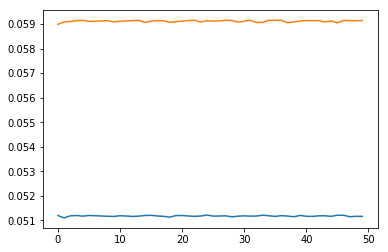

In [61]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

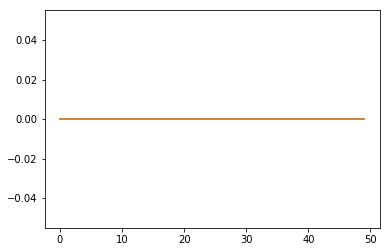

In [62]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

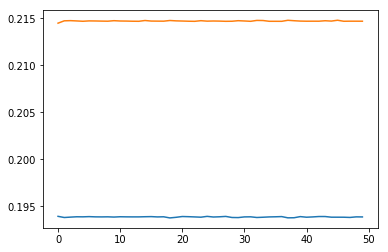

In [63]:
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])

In [64]:
y_train[:10]

array([0.7444838 , 0.73133816, 0.49867375, 0.22841064, 0.6903638 ,
       0.1788503 , 0.6591156 , 0.22500947, 0.60857797, 0.73256912])

In [65]:
f = [0.1, 0.429, 0.856, 1.4]
y = ae.predict(f)
y

array([[0.41256344],
       [0.41256344],
       [0.41256344],
       [0.4125634 ]], dtype=float32)

In [66]:
y_train[y_train.argmax()]

0.7992837066789173

In [67]:
y_train[y_train.argmin()]

0.00047235205807517053

m (50, 1)


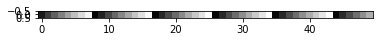

m (50, 1)


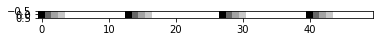

array([0.7444838 , 0.73133816])

In [68]:
f = y_train[:10]
y = decoder_model.predict(f)
plot.single(y[0,:50,0])
plot.single(x_train[0,:50,0])
# plot.single(x_train[1,:50,0])
f[:2]

m (50, 1)


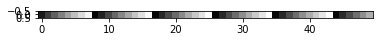

m (50, 1)


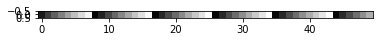

m (50, 1)


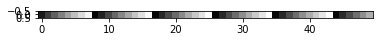

m (50, 1)


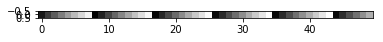

In [71]:
f = [0.01, 0.5, 0.8, 1.4]
y = decoder_model.predict(f)
plot.single(y[0,:50,0])
plot.single(y[1,:50,0])
plot.single(y[2,:50,0])
plot.single(y[3,:50,0])

m (50, 1)


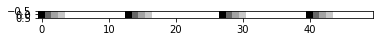

m (50, 1)


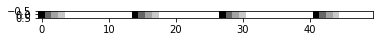

m (90, 1)


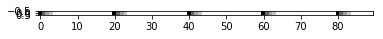

m (90, 1)


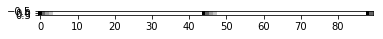

In [46]:
# goal examples
plot.single(x_train[0,:50,0])
plot.single(x_train[1,:50,0])
plot.single(x_train[2,:90,0])
plot.single(x_train[3,:90,0])

In [47]:
y_train[:5]

array([0.7444838 , 0.73133816, 0.49867375, 0.22841064, 0.6903638 ])